In [1]:
import numpy as np
import pandas as pd
from datetime import date
import os

# Custom Libraries -->
%load_ext autoreload
%autoreload 2
from src.portfolio import Portfolio
from src.simulation import MonteCarloSimulation
from src.tradier import Tradier

In [2]:
%load_ext dotenv
%dotenv
access_token = os.environ.get("access_token")

SYMBOL = "AAPL"
START_DATE = "2015-01-01"
END_DATE = "2023-12-30"

tradier = Tradier(access_token)

In [3]:
daily_std = tradier.getVolatility(SYMBOL, START_DATE, END_DATE)
print("Daily STD:", daily_std)

price = tradier.getMarketPrice(SYMBOL)
print("Price:", price)

Daily STD: 1.1762302461820597
Price: 185.85


In [4]:
expiration_dates = tradier.getSymbolExpirationDates(SYMBOL)
print("Expiration Dates:", expiration_dates)

expiration = expiration_dates[8]
today = date.today()
NUM_OF_DAYS = np.busday_count(today, expiration)

Expiration Dates: ['2024-02-09', '2024-02-16', '2024-02-23', '2024-03-01', '2024-03-08', '2024-03-15', '2024-03-22', '2024-04-19', '2024-05-17', '2024-06-21', '2024-07-19', '2024-08-16', '2024-09-20', '2024-12-20', '2025-01-17', '2025-03-21', '2025-06-20', '2025-09-19', '2025-12-19', '2026-01-16', '2026-06-18']


In [5]:
json_response = tradier.getOptionChain(SYMBOL, expiration)

call_strikes = [entry['strike'] if entry['option_type'] == "call" else None for entry in json_response['options']['option']]
call_bids = [entry['ask'] if entry['option_type'] == "call" else None for entry in json_response['options']['option']]
call_asks = [entry['bid'] if entry['option_type'] == "call" else None for entry in json_response['options']['option']]

put_strikes = [entry['strike'] if entry['option_type'] == "put" else None for entry in json_response['options']['option']]
put_bids = [entry['bid'] if entry['option_type'] == "put" else None for entry in json_response['options']['option']]
put_asks = [entry['ask'] if entry['option_type'] == "put" else None for entry in json_response['options']['option']]

option_data = {
    'call_strikes': call_strikes,
    'call_bids': call_bids,
    'call_asks': call_asks,
    'put_strikes': put_strikes,
    'put_bids': put_bids,
    'put_asks': put_asks
}

call_df = pd.DataFrame({
    'strikes': call_strikes,
    'bids': call_bids,
    'asks': call_asks,
})

put_df = pd.DataFrame({
    'strikes': call_strikes,
    'bids': call_bids,
    'asks': call_asks,
})

call_df.to_csv("data/call_option_chain.csv", index=False)
put_df.to_csv("data/put_option_chain.csv", index=False)

In [6]:
std = daily_std * np.sqrt(NUM_OF_DAYS)
print("Adjusted Standard Deviation:", std)

STD_WIDTH = 3
prices = np.arange(price - STD_WIDTH * std, price + STD_WIDTH * std, 1)

Adjusted Standard Deviation: 10.118315166591701


Portfolio:
Cost per trade:  20.55
Strike: 190.0 Premium: 7.55 Type: Call Side: Long
Strike: 190.0 Premium: 9.4 Type: Put Side: Short
Strike: 200.0 Premium: 3.6 Type: Call Side: Short


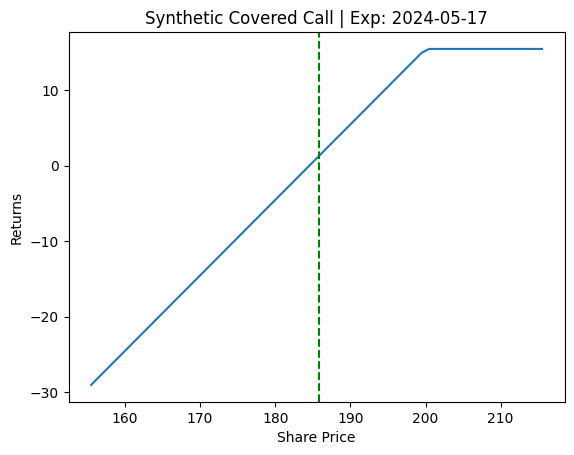

In [7]:
covered_call_strat = Portfolio(option_data, [
    # ATM Call PUT
    (price, expiration, 'Call', 'Long'),
    
    # ATM SHORT PUT
    (price, expiration, 'Put', 'Short'),
    
    # OTM SHORT CALL
    (price + std, expiration, 'Call', 'Short'),
])

# covered_call_strat.log()
covered_call_strat.draw(prices, price, std, expiration, showMarkers=True)

Portfolio:
Cost per trade:  11.15
Strike: 190.0 Premium: 7.55 Type: Call Side: Long
Strike: 200.0 Premium: 3.6 Type: Call Side: Short


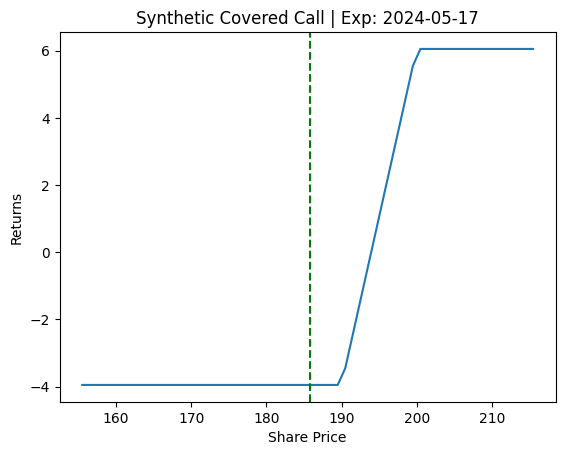

In [8]:
long_call = Portfolio(option_data, [
    (price, expiration, 'Call', 'Long'),
    (price+std, expiration, 'Call', 'Short'),
])

long_call.draw(prices, price, std, expiration, showMarkers=True)

Portfolio:
Cost per trade:  16.5
Strike: 190.0 Premium: 9.4 Type: Put Side: Long
Strike: 185.0 Premium: 7.1 Type: Put Side: Short


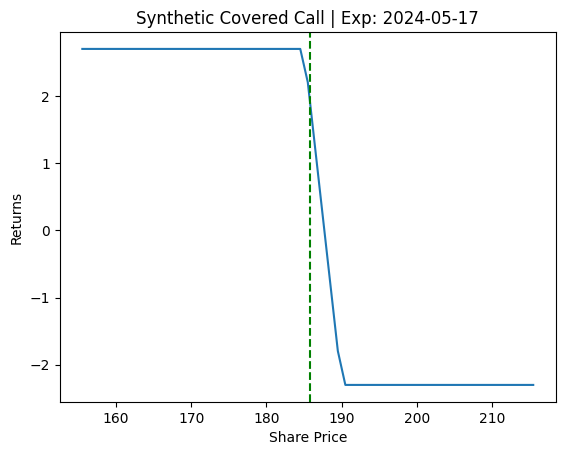

In [9]:
bear_put_spread = Portfolio(option_data, [
    (price, expiration, 'Put', 'Long'),
    (price-std, expiration, 'Put', 'Short'),
])

bear_put_spread.draw(prices, price, std, expiration, showMarkers=True)

Portfolio:
Cost per trade:  16.95
Strike: 190.0 Premium: 7.55 Type: Call Side: Long
Strike: 190.0 Premium: 9.4 Type: Put Side: Long


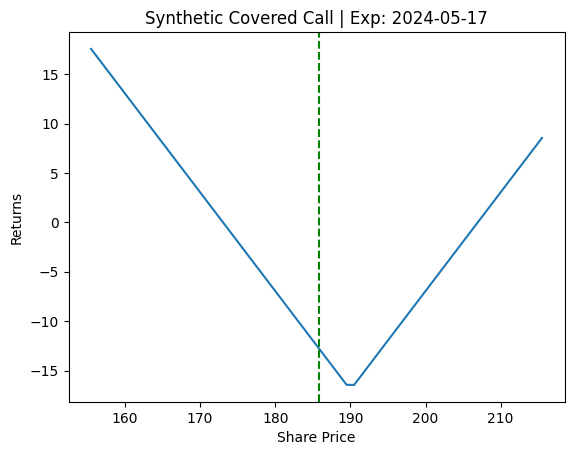

In [10]:
long_straddle = Portfolio(option_data, [
    (price, expiration, 'Call', 'Long'),
    (price, expiration, 'Put', 'Long'),
])

long_straddle.draw(prices, price, std, expiration, showMarkers=True)

Portfolio:
Cost per trade:  10.7
Strike: 200.0 Premium: 3.6 Type: Call Side: Long
Strike: 185.0 Premium: 7.1 Type: Put Side: Long


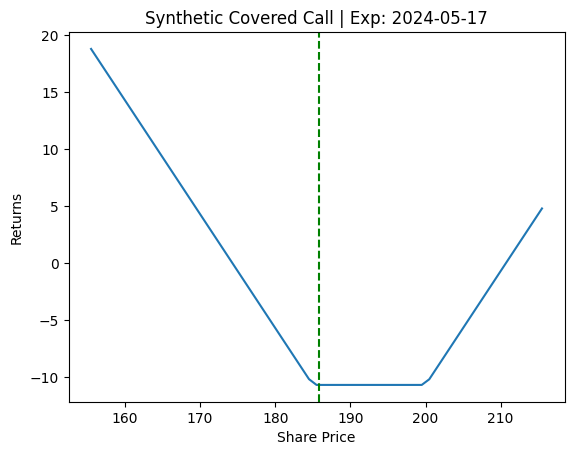

In [11]:
long_strangle = Portfolio(option_data, [
    (price+std, expiration, 'Call', 'Long'),
    (price-std, expiration, 'Put', 'Long'),
])

long_strangle.draw(prices, price, std, expiration, showMarkers=True)

Portfolio:
Cost per trade:  22.270000000000003
Strike: 210.0 Premium: 1.52 Type: Call Side: Long
Strike: 190.0 Premium: 7.55 Type: Call Side: Short
Strike: 175.0 Premium: 3.8 Type: Put Side: Long
Strike: 190.0 Premium: 9.4 Type: Put Side: Short


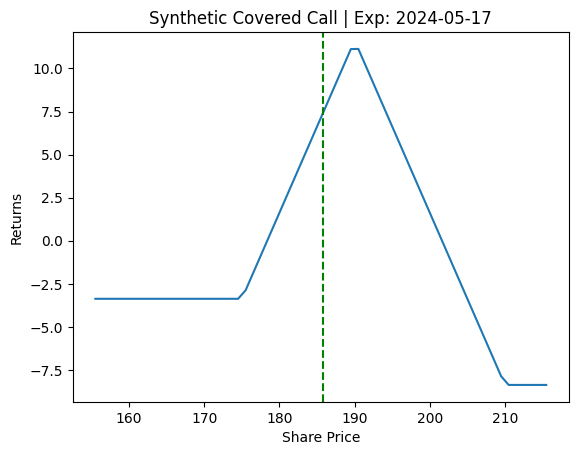

In [12]:
long_call_butterfly_spread = Portfolio(option_data, [
    (price+2*std, expiration, 'Call', 'Long'),
    (price, expiration, 'Call', 'Short'),
    
    (price-2*std, expiration, 'Put', 'Long'),
    (price, expiration, 'Put', 'Short'),
])

long_call_butterfly_spread.draw(prices, price, std, expiration, showMarkers=True)

Portfolio:
Cost per trade:  16.02
Strike: 185.0 Premium: 7.1 Type: Put Side: Short
Strike: 175.0 Premium: 3.8 Type: Put Side: Long
Strike: 200.0 Premium: 3.6 Type: Call Side: Short
Strike: 210.0 Premium: 1.52 Type: Call Side: Long


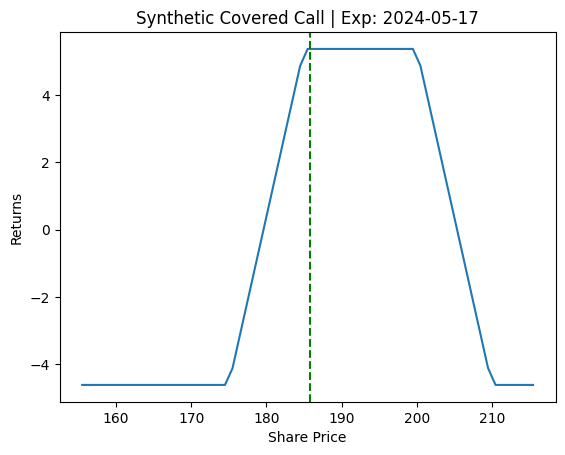

In [13]:
iron_condor_spread = Portfolio(option_data, [
    (price-std, expiration, 'Put', 'Short'),
    (price-2*std, expiration, 'Put', 'Long'),

    (price+std, expiration, 'Call', 'Short'),
    (price+2*std, expiration, 'Call', 'Long'),
    
])

iron_condor_spread.draw(prices, price, std, expiration, showMarkers=True)

Portfolio:
Cost per trade:  44.00000000000001
Strike: 180.0 Premium: 13.25 Type: Call Side: Long
Strike: 185.0 Premium: 7.1 Type: Put Side: Short
Strike: 205.0 Premium: 20.05 Type: Put Side: Long
Strike: 200.0 Premium: 3.6 Type: Call Side: Short
Portfolio:
Cost per trade:  44.00000000000001
Strike: 180.0 Premium: 13.25 Type: Call Side: Long
Strike: 185.0 Premium: 7.1 Type: Put Side: Short
Strike: 205.0 Premium: 20.05 Type: Put Side: Long
Strike: 200.0 Premium: 3.6 Type: Call Side: Short


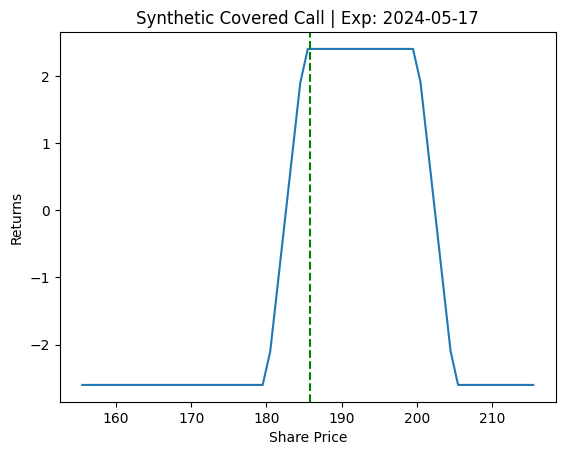

In [14]:
box_spread = Portfolio(option_data, [
    (price-std, expiration, 'Call', 'Long'),
    (price-std, expiration, 'Put', 'Short'),
    
    (price+std, expiration, 'Put', 'Long'),
    (price+std, expiration, 'Call', 'Short'),
])

box_spread.log()
box_spread.draw(prices, price, std, expiration, showMarkers=True)